In [1]:
from Deproject_v1 import *
from Deproject_test import *
from Deproject_plots import *
from scipy import sparse as scisp
from scipy.optimize import approx_fprime
import os
import cProfile
plt.style.use('classic')

In [2]:
N = 500 #Number of stars we want to use in our sample
v0 = np.array([2,1,-3]) #The mean velocities of our pseudosample Gaussian velocity distributions
v_disp = np.array([60,50,55]) #The velocity dispersions of the Gaussians
sample = model_sample(N,v0,v_disp) #Uncomment to use pseudosample

In [3]:
#Oort constant values from Bovy (2018)
A = (15.3*(u.km/(u.s*u.kpc))).to(1/u.yr)
B = (-11.9*(u.km/(u.s*u.kpc))).to(1/u.yr)

bvals = sample.b.to(u.deg)
lvals = sample.l.to(u.deg)

mul_obs = sample.pm_l_cosb.to(1/u.yr,equivalencies = u.dimensionless_angles())
mub_obs = sample.pm_b.to(1/u.yr,equivalencies = u.dimensionless_angles())

"""Computation of the relevant quantities

    l,b: Galactic coordinates
    s: the distance obtained by inverting the parallax
    mul, mub: proper motion in l and b
    pvals: Tangential velocities obtained from eq. 2 in DB98
    rhatvals: The unit vector of each star
    vmin: Vector containing the minimum velocities in v-space
    n: The number of cells we want in each dimension of our v-space box
    dv: Step sizes for each dimension"""

b = np.deg2rad(bvals).value # just a test
l = np.deg2rad(lvals).value
cosl = np.cos(l)
cosb = np.cos(b)
sinl = np.sin(l)
sinb = np.sin(b)
s = sample.distance

mul = mul_obs - A*np.cos(2*l)-B
mub = mub_obs + A*np.sin(2*l)*cosb*sinb

pvals = s*np.array([-sinl*cosb*mul - cosl*sinb*mub,
                 cosl*cosb*mul - sinl*sinb*mub,
                 cosb*mub])/u.yr
    
rhatvals = np.array([cosb*cosl, cosb*sinl, sinb]).T
pvals = pvals.to(u.km/u.s).value.T

In [4]:
#For example we can choose

n = np.array([25,25,25])
dv = np.array([12,12,12])
vmin = np.array([-150,-150,-150])

In [5]:
#Test of phi_guess

sigma2, vmean0 = calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)

vmean_g = np.array([10,15,-10])

phi0 = phi_guess(vmean_g,sigma,vmin,dv,n)+(np.random.random((n))*10)

sanity_check(pvals,rhatvals,phi0,vmin,dv,n)

Computed mean ===> [  9.49362768  15.26964536  -8.4420324 ]
Computed velocity dispersion ===> [ 47.69492312  43.81626232  52.22146808]
Sample mean ===> [  8.54241352e+00   7.42380850e-03  -6.31321320e+00]
Sample velocity dispersion ===> [ 46.9547849   42.74739908  53.5207943 ]


# Test of the gradient calculator

I did some things explicitly here (I'm sure they are done more efficiently elsewhere, but I wanted to check)

The below just calculates grad_negL numerically and using the analytical formula.

In [8]:
import copy
dvx, dvy, dvz = dv
nx, ny, nz = n
N = len(pvals)
alpha = 1e-6
sigma2 = calc_sigma2(pvals,rhatvals) 

K0 = np.ravel(calc_K(pvals[0],rhatvals[0],vmin,dv,n))
    
Kvals = scisp.coo_matrix(K0)

for i in range(1,N): #Loop that yield a sparse array of N K-values

    K = np.ravel(calc_K(pvals[i],rhatvals[i],vmin,dv,n))
    K_coo = scisp.coo_matrix(K)

    Kvals = scisp.vstack((Kvals,K_coo))

Kvals_csc = Kvals.tocsc()

phi0r = np.ravel(phi0)

args = Kvals_csc, N, alpha, dv, n, sigma2

negL = get_negL(phi0r, Kvals_csc, N, alpha, dv, n, sigma2)
grad_negL = get_grad_negL(phi0r, Kvals_csc, N, alpha, dv, n, sigma2)

#grad_negL

#phi0r
grad_negL_num = np.zeros_like(phi0r)

for i in range(len(grad_negL_num)) :
    phitmp = copy.copy(phi0r)
    phitmp[i] += 0.001
    grad_negL_num[i] = (get_negL(phitmp, Kvals_csc, N, alpha, dv, n, sigma2)-negL)/0.001


#plt.plot(grad_negL_num/grad_negL,marker='.')
#plt.ylim(0,2)
#plt.show()

# Where do the problems lie?

Check which values are problematic

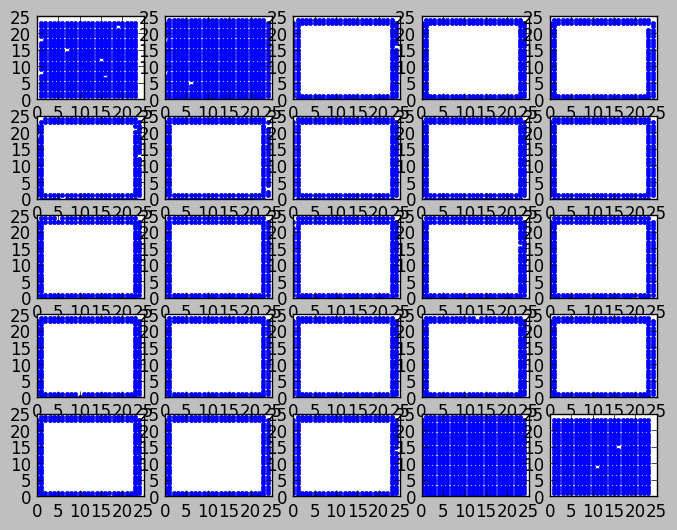

In [10]:

# mask to show only erroneous values, where the numerical gradient is non-negligible

mask = ((grad_negL_num/grad_negL -1)**2 > 0.5) & (grad_negL_num**2>1e-2)

# Plot the points as x,y,z - I am sure there is a better (more python-y) way of doing this, 
# but the below made sense to me
xtmp = np.arange(0,len(grad_negL))[mask]//(n[1]*n[2])
ytmp = (np.arange(0,len(grad_negL))[mask]//n[1])%n[2]
ztmp = np.arange(0,len(grad_negL))[mask]%n[0]


# For the first 9 rowas only

for i in range(25) :
    plt.subplot(5,5,i+1)
    mask = xtmp==i
    plt.plot(ytmp[mask],ztmp[mask],'.')

plt.show()

# For clarity, show a central slice

Problems are clearly in the two edge rows (but not corners, for some reason)

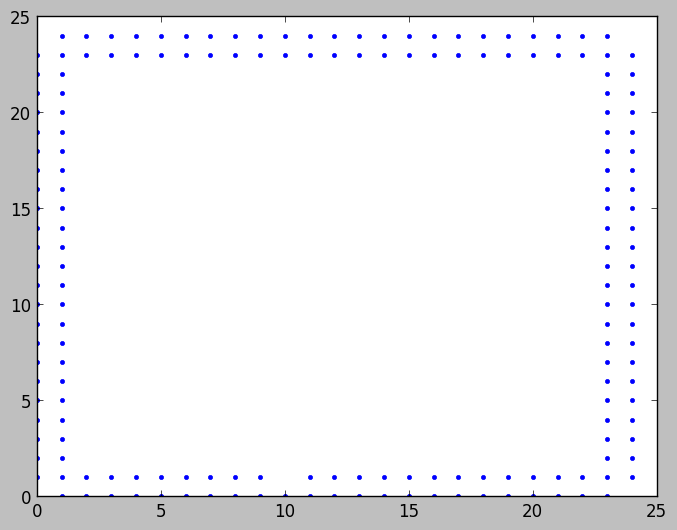

In [12]:

    
mask = xtmp==15
plt.plot(ytmp[mask],ztmp[mask],'.')
plt.show()
